In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
pd.set_option('mode.chained_assignment',  None)

SMART_CARD = pd.read_csv('./data/SMART_CARD.csv')

# getrouteinfoall
getrouteinfoall = pd.read_csv('./data/getRouteInfoAll.csv', encoding = 'cp949', index_col = 0)
getrouteinfoall_df = getrouteinfoall[['ROUTE_CD','ROUTE_NO']]

### gestationbyrouteall
getstationbyrouteall = pd.read_csv('./data/getStationByRouteAll.csv', encoding = 'cp949', index_col = 0)

In [2]:
def smart_card_preprocessing(exdata): # 스마트카드 데이터 전처리
    exdata.columns = ['SERIAL_NO', 'CARD_NO', 'GETON_YMD', 'GETON_TM', 'BUS_ROUTE_ID', 'BUS_CO_ID', 'BUS_CAR_ID', 'GETON_BUS_STTN_ID', 'GETOFF_BUS_STTN_ID',
                      'DRVR_ID', 'TRANSACTION_ID', 'TR_MEANS_TYPE', 'USR_TYPE', 'DRVN_START_YMD', 'DRVN_START_TM', 'GETOFF_YMD', 'GETOFF_TM', 'GETON_CALC_YMD',
                      'GETOFF_CALC_YMD', 'GETON_PAY', 'GETOFF_PAY', 'TRANSF_CNT', 'USR_CNT']
    
    exdata = exdata[exdata['GETOFF_BUS_STTN_ID']!='~      '] # 하차 태그 없는 데이터 제거
    
    # 601,704, 912,701,602,108,211만 추출
    exdata = exdata[exdata['BUS_ROUTE_ID'].isin([30300068,30300088,30300145,30300086,30300069,30300043,30300053])]
    
    # GETON_TM 컬럼 날짜형식으로 변환하기 위해 자릿수 맞춰주기
    exdata['GETON_TM'] = exdata['GETON_TM'].apply(lambda x: str(x).zfill(6))
    exdata['DRVN_START_TM'] = exdata['DRVN_START_TM'].apply(lambda x: str(x).zfill(6))
        
    # datetime 형식으로 변환 및 새로운 column 생성
    exdata['GETON_DATETIME'] = pd.to_datetime(exdata['GETON_YMD'].astype(str) + exdata['GETON_TM'].astype(str), format = '%Y%m%d%H%M%S')
    exdata['GETOFF_DATETIME'] = pd.to_datetime(exdata['GETOFF_YMD'].astype(str) + exdata['GETOFF_TM'].astype(str), format = '%Y%m%d%H%M%S')
    exdata['DRVN_START_DATETIME'] = pd.to_datetime(exdata['DRVN_START_YMD'].astype(str) + exdata['DRVN_START_TM'].astype(str), format = '%Y%m%d%H%M%S')
    
    exdata['DAY'] = exdata['GETON_DATETIME'].dt.day
    exdata['WEEKDAY'] = exdata['GETON_DATETIME'].dt.weekday  
    exdata['GETON_HOUR'] = exdata['GETON_DATETIME'].dt.hour

    # 평일만 추출
    weekday_values = [0, 1, 2, 3, 4]
    exdata = exdata[exdata['WEEKDAY'].isin(weekday_values)]

    # 6/6일 제거
    exdata = exdata[exdata['DAY'] != 6]
    
    # 비가 온 날 제거
    exdata = exdata[~exdata['DAY'].isin([26,29])]
    
    # int형으로 변환
    exdata['GETOFF_BUS_STTN_ID'] = exdata['GETOFF_BUS_STTN_ID'].astype(int)
    
    # # 여러명이 탄 경우 제거
    # exdata = exdata[exdata['USR_CNT']==1]
    
    # 사용한 행 제거
    exdata.drop(labels = ['GETON_YMD','GETON_TM','GETOFF_YMD','GETOFF_TM','DRVN_START_YMD','DRVN_START_TM'], axis = 1, inplace = True)

    # 필요없는 행 제거
    exdata.drop(labels = ['SERIAL_NO', 'DRVR_ID','GETON_PAY','GETOFF_PAY','USR_TYPE','GETON_CALC_YMD', 'GETOFF_CALC_YMD', 'TRANSACTION_ID','TR_MEANS_TYPE','WEEKDAY'], axis = 1, inplace = True)
    
    # exdata = exdata[['CARD_NO','BUS_ROUTE_ID', 'TR_MEANS_TYPE', 'GETON_BUS_STTN_ID', 'GETON_DATETIME', 'GETOFF_BUS_STTN_ID', 'GETOFF_DATETIME','DAY']]
    return exdata

In [3]:
SMART_CARD_DATA = smart_card_preprocessing(SMART_CARD)
SMART_CARD_DATA_MERGE = SMART_CARD_DATA.merge(getrouteinfoall_df, left_on = 'BUS_ROUTE_ID', right_on = 'ROUTE_CD')
SMART_CARD_DATA_MERGE = SMART_CARD_DATA_MERGE[['CARD_NO','ROUTE_NO','ROUTE_CD','BUS_CO_ID','BUS_CAR_ID','GETON_BUS_STTN_ID','GETON_DATETIME','GETOFF_BUS_STTN_ID','GETOFF_DATETIME','DRVN_START_DATETIME','TRANSF_CNT','USR_CNT','DAY','GETON_HOUR']]
SMART_CARD_DATA_MERGE.head(2)

,CARD_NO,ROUTE_NO,ROUTE_CD,BUS_CO_ID,BUS_CAR_ID,GETON_BUS_STTN_ID,GETON_DATETIME,GETOFF_BUS_STTN_ID,GETOFF_DATETIME,DRVN_START_DATETIME,TRANSF_CNT,USR_CNT,DAY,GETON_HOUR
0,929954937,108,30300043,130010015,130759616,8001243,2023-06-01 05:30:22,8002717,2023-06-01 05:59:28,2023-06-01 05:29:47,199,1,1,5
1,943538994,108,30300043,130010015,130759616,8001243,2023-06-01 05:30:25,8005590,2023-06-01 06:16:11,2023-06-01 05:29:47,199,1,1,5


In [4]:
# 601번만 필터링
BUS_601 = SMART_CARD_DATA_MERGE[SMART_CARD_DATA_MERGE['ROUTE_NO']=='601']

# 704번만 필터링
BUS_704 = SMART_CARD_DATA_MERGE[SMART_CARD_DATA_MERGE['ROUTE_NO']=='704']

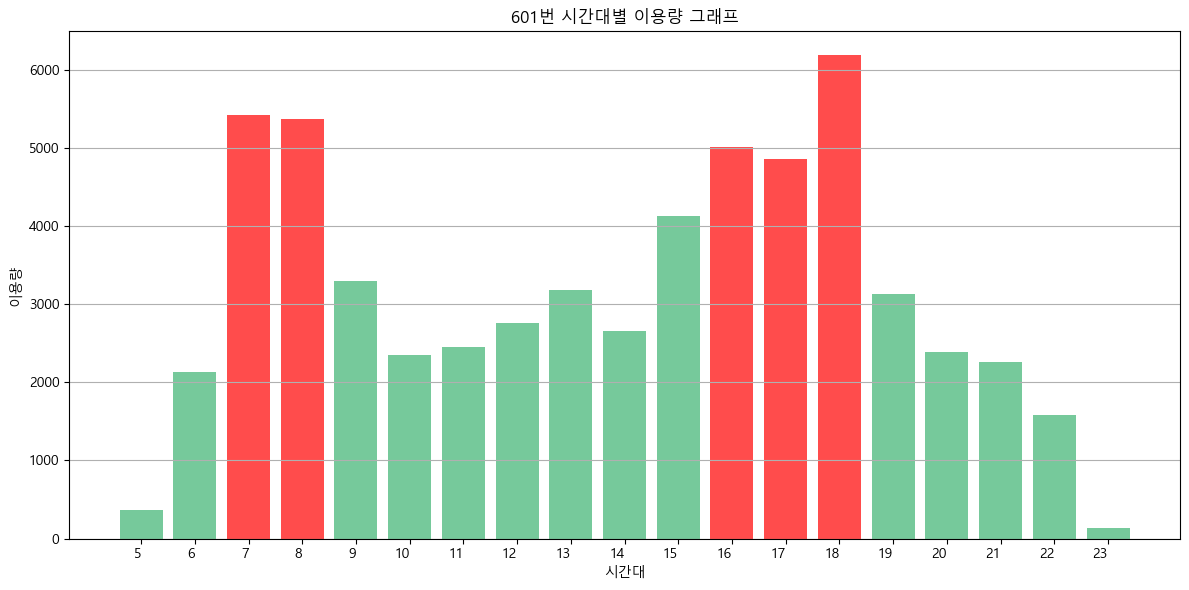

In [5]:
import matplotlib.pyplot as plt

# GETON_HOUR 열을 기준으로 데이터를 그룹화하고 SIZE를 계산
hourly_counts = BUS_601.groupby('GETON_HOUR').size()

# 상위 5개 항목을 선택하여 빨간색으로 표시
top_5_hours = hourly_counts.nlargest(5)
top_5_labels = top_5_hours.index

# 그래프 생성
plt.rc('font', family='malgun gothic')
plt.figure(figsize=(12, 6))
colors = ['mediumseagreen' if hour not in top_5_labels else 'red' for hour in hourly_counts.index]
plt.bar(hourly_counts.index, hourly_counts, color=colors, alpha=0.7)
plt.title('601번 시간대별 이용량 그래프')
plt.xlabel('시간대')
plt.ylabel('이용량')

# X 축 레이블 모두 표시
plt.xticks(hourly_counts.index, rotation=0, ha='right')

plt.grid(axis='y')

# 그래프 표시
plt.tight_layout()
plt.show()


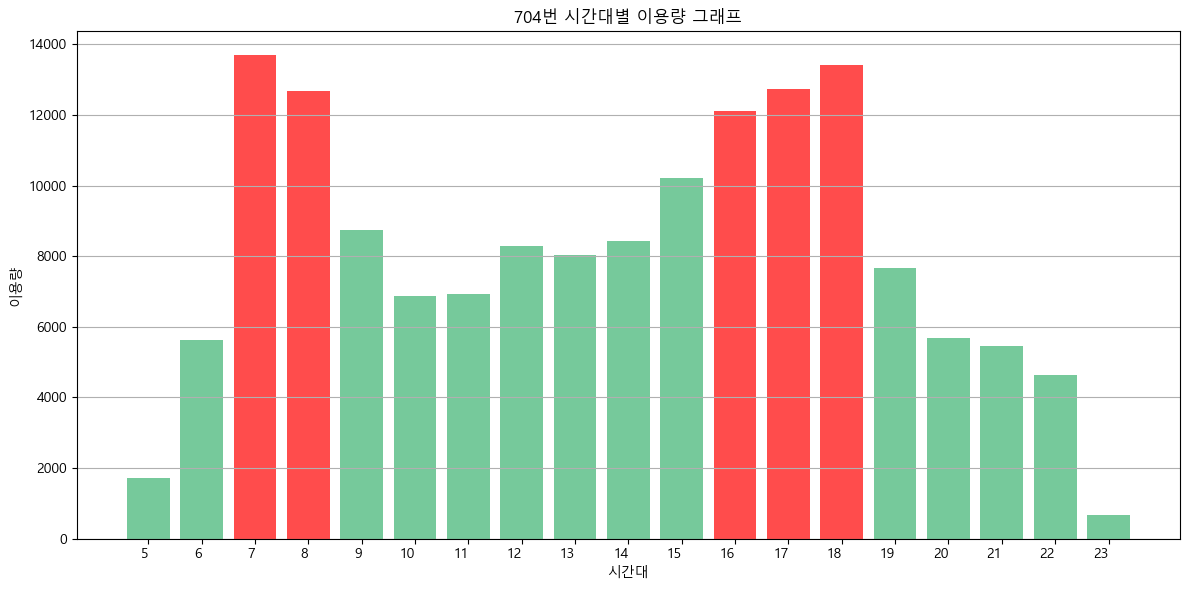

In [6]:
import matplotlib.pyplot as plt

# GETON_HOUR 열을 기준으로 데이터를 그룹화하고 SIZE를 계산
hourly_counts = BUS_704.groupby('GETON_HOUR').size()

# 상위 5개 항목을 선택하여 빨간색으로 표시
top_5_hours = hourly_counts.nlargest(5)
top_5_labels = top_5_hours.index

# 그래프 생성
plt.rc('font', family='malgun gothic')
plt.figure(figsize=(12, 6))
colors = ['mediumseagreen' if hour not in top_5_labels else 'red' for hour in hourly_counts.index]
plt.bar(hourly_counts.index, hourly_counts, color=colors, alpha=0.7)
plt.title('704번 시간대별 이용량 그래프')
plt.xlabel('시간대')
plt.ylabel('이용량')

# X 축 레이블 모두 표시
plt.xticks(hourly_counts.index, rotation=0, ha='right')

plt.grid(axis='y')

# 그래프 표시
plt.tight_layout()
plt.show()


---

In [7]:
day_values = [1, 2, 5, 7, 8, 9, 12, 13, 14, 15, 16, 20, 21, 22, 23, 27, 28, 30]

def get_date_df1(exdata, date):
    exdata = exdata[exdata['DAY']==date]
    exdata = exdata[exdata['GETON_HOUR'].isin([7,8])]
    exdata['DRVN_START_HOUR'] = exdata['DRVN_START_DATETIME'].dt.hour
    return exdata

def get_date_df2(exdata, date):
    exdata = exdata[exdata['DAY']==date]
    exdata = exdata[exdata['GETON_HOUR'].isin([16,17,18])]
    exdata['DRVN_START_HOUR'] = exdata['DRVN_START_DATETIME'].dt.hour
    return exdata

In [8]:
for date in day_values:
    df_name = f'BUS_601_{date}_morning'
    globals()[df_name] = get_date_df1(BUS_601, date)
    
for date in day_values:
    df_name = f'BUS_601_{date}_night'
    globals()[df_name] = get_date_df2(BUS_601, date)

601번

In [9]:
BUS_601_morning = BUS_601[BUS_601['GETON_HOUR'].isin([7,8])]
BUS_601_morning['DRVN_START_HOUR'] = BUS_601_morning['DRVN_START_DATETIME'].dt.hour
BUS_601_morning['DRVN_START_HOUR'].value_counts()

DRVN_START_HOUR
7    4485
6    3405
8    1476
5    1431
4       5
Name: count, dtype: int64

In [10]:
BUS_601_night = BUS_601[BUS_601['GETON_HOUR'].isin([16,17,18])]
BUS_601_night['DRVN_START_HOUR'] = BUS_601_night['DRVN_START_DATETIME'].dt.hour
BUS_601_night['DRVN_START_HOUR'].value_counts()

DRVN_START_HOUR
16    4912
17    3678
15    3508
18    1920
14    1345
13     331
12     165
11     123
10      75
Name: count, dtype: int64

704번

In [11]:
BUS_704_morning = BUS_704[BUS_704['GETON_HOUR'].isin([7,8])]
BUS_704_morning['DRVN_START_HOUR'] = BUS_704_morning['DRVN_START_DATETIME'].dt.hour
BUS_704_morning['DRVN_START_HOUR'].value_counts()

DRVN_START_HOUR
7     11390
6      9146
8      3418
5      2398
22        6
Name: count, dtype: int64

In [12]:
BUS_601['DRVN_START_HOUR'] = BUS_601['DRVN_START_DATETIME'].dt.hour
BUS_704['DRVN_START_HOUR'] = BUS_704['DRVN_START_DATETIME'].dt.hour
BUS_601['DRVN_START_HOUR'].value_counts()

DRVN_START_HOUR
7     5287
16    5238
15    4970
6     4569
17    4222
14    4009
13    3397
18    3274
8     3121
12    3095
5     3089
9     3084
11    2998
19    2573
10    2498
20    2250
21    1328
22     679
4       17
Name: count, dtype: int64

In [13]:
BUS_704['DRVN_START_HOUR'].value_counts()

DRVN_START_HOUR
6     13720
7     13259
16    12502
15    12439
14    11744
17    11404
12     9140
13     9048
8      8291
5      7678
11     7436
9      7356
10     6894
18     6894
19     5302
20     5087
21     4079
22     1289
Name: count, dtype: int64

In [14]:
BUS_704_night = BUS_704[BUS_704['GETON_HOUR'].isin([16,17,18])]
BUS_704_night['DRVN_START_HOUR'] = BUS_704_night['DRVN_START_DATETIME'].dt.hour
BUS_704_night['DRVN_START_HOUR'].value_counts()

DRVN_START_HOUR
16    11701
17     9615
15     9239
14     3617
18     2488
13     1217
12      340
11       46
Name: count, dtype: int64

대기시간 비용 구하기

In [15]:
from datetime import datetime

getrouteinfoall_df2 = getrouteinfoall[['ROUTE_NO', 'ALLO_INTERVAL','ORIGIN_START','ORIGIN_END','TURN_START','TURN_END']]
getrouteinfoall_df2 = getrouteinfoall_df2[getrouteinfoall_df2['ROUTE_NO'].isin(['601','912','701','602','704','108','211'])]

# 앞에 0을 추가하여 시간 타입으로 바꿀 수 있도록 함
getrouteinfoall_df2['ORIGIN_START'] = getrouteinfoall_df2['ORIGIN_START'].apply(lambda x: str(x).zfill(4))
getrouteinfoall_df2['TURN_START'] = getrouteinfoall_df2['TURN_START'].apply(lambda x: str(x).zfill(4))

# 시간 형식으로 변환
getrouteinfoall_df2['ORIGIN_START'] = pd.to_datetime(getrouteinfoall_df2['ORIGIN_START'], format = '%H%M')
getrouteinfoall_df2['ORIGIN_END'] = pd.to_datetime(getrouteinfoall_df2['ORIGIN_END'], format='%H%M')
getrouteinfoall_df2['TURN_START'] = pd.to_datetime(getrouteinfoall_df2['TURN_START'], format='%H%M')
getrouteinfoall_df2['TURN_END'] = pd.to_datetime(getrouteinfoall_df2['TURN_END'], format='%H%M')

# ORIGIN_TIME_DIFF와 TURN_TIME_DIFF 열 생성
getrouteinfoall_df2['ORIGIN_TIME_DIFF'] = (getrouteinfoall_df2['ORIGIN_END'] - getrouteinfoall_df2['ORIGIN_START']).dt.total_seconds() / 60
getrouteinfoall_df2['TURN_TIME_DIFF'] = (getrouteinfoall_df2['TURN_END'] - getrouteinfoall_df2['TURN_START']).dt.total_seconds() / 60

# 정수로 변환
getrouteinfoall_df2['ORIGIN_TIME_DIFF'] = getrouteinfoall_df2['ORIGIN_TIME_DIFF'].astype(int)
getrouteinfoall_df2['TURN_TIME_DIFF'] = getrouteinfoall_df2['TURN_TIME_DIFF'].astype(int)

# 이용 대수 계산
getrouteinfoall_df2['ALLO_INTERVAL'] = getrouteinfoall_df2['ALLO_INTERVAL'].astype(int)
getrouteinfoall_df2['ORIGIN_BUS_CNT'] = getrouteinfoall_df2['ORIGIN_TIME_DIFF'] // getrouteinfoall_df2['ALLO_INTERVAL']
getrouteinfoall_df2['TURN_BUS_CNT'] = getrouteinfoall_df2['TURN_TIME_DIFF'] // getrouteinfoall_df2['ALLO_INTERVAL']
getrouteinfoall_df2['TOTAL_BUS_CNT'] = getrouteinfoall_df2['ORIGIN_BUS_CNT'] + getrouteinfoall_df2['TURN_BUS_CNT']
getrouteinfoall_df2['TOTAL_BUS_CNT_WORK'] = ((300 / getrouteinfoall_df2['ALLO_INTERVAL'])*2).astype(int)

# 사용한 행 제거
getrouteinfoall_df2.drop(labels = ['ORIGIN_START','ORIGIN_END','TURN_START','TURN_END', 'ORIGIN_BUS_CNT','TURN_BUS_CNT'], axis = 1, inplace = True)

getrouteinfoall_df2.head(10)

,ROUTE_NO,ALLO_INTERVAL,ORIGIN_TIME_DIFF,TURN_TIME_DIFF,TOTAL_BUS_CNT,TOTAL_BUS_CNT_WORK
34,108,12,1015,1015,168,50
43,211,12,1015,1015,168,50
58,601,21,1020,1020,96,28
59,602,18,1015,1020,112,33
75,701,18,1010,1010,112,33
77,704,14,1005,1020,143,42
104,912,19,1010,1010,106,31


In [16]:
# 버스데이터에 배차간격 추가
def plus_allo_interval(exdata,getrouteinfoall_df2):
    exdata = exdata.merge(getrouteinfoall_df2, left_on = 'ROUTE_NO', right_on = 'ROUTE_NO')
    exdata.drop(labels = ['ROUTE_CD','BUS_CO_ID','TRANSF_CNT','USR_CNT','DAY'], axis = 1, inplace = True)
    return exdata

def cal_waiting_time_1(exdata, minute):
    allo_interval = int(exdata['ALLO_INTERVAL'].values[0])
    wating_time_costs = allo_interval/ 2 * len(exdata[exdata['DRVN_START_HOUR'].isin([6, 7, 16, 17, 15])]) + allo_interval / 2 * len(exdata[~exdata['DRVN_START_HOUR'].isin([6, 7, 16, 17, 15])]) # 기존 배차간격의 대기시간 비용 합
    wating_time = (allo_interval - minute) / 2 * len(exdata[exdata['DRVN_START_HOUR'].isin([6, 7, 16, 17, 15])]) + allo_interval / 2 * len(exdata[~exdata['DRVN_START_HOUR'].isin([6, 7, 16, 17, 15])])
    # print('배차 시간이', allo_interval - minute, '분일 때, 대기시간 비용 합:', wating_time)
    print('배차 시간이', minute, '분 감소할 때, 변경된 배차 시간 :',allo_interval - minute, '분 대기시간 비용 합:', int(wating_time), '이익 : ', int(wating_time_costs - wating_time))

def cal_waiting_time_2(exdata, minute):
    allo_interval = int(exdata['ALLO_INTERVAL'].values[0])
    wating_time_costs = allo_interval/ 2 * len(exdata) # 기존 배차간격의 대기시간 비용 합
    wating_time = (allo_interval + minute) / 2 * len(exdata)
    # print('배차 시간이', allo_interval - minute, '분일 때, 대기시간 비용 합:', wating_time)
    print('배차 시간이', minute, '분 증가할 때, 변경된 배차 시간 :',allo_interval + minute, '분 대기시간 비용 합:', int(wating_time), '손실 : ', int(wating_time_costs - wating_time))

---

In [17]:
# 912번, 701번, 602번만 필터링
BUS_912 = SMART_CARD_DATA_MERGE[SMART_CARD_DATA_MERGE['ROUTE_NO']=='912']
BUS_701 = SMART_CARD_DATA_MERGE[SMART_CARD_DATA_MERGE['ROUTE_NO']=='701']
BUS_602 = SMART_CARD_DATA_MERGE[SMART_CARD_DATA_MERGE['ROUTE_NO']=='602']

# 108번, 211번만 필터링
BUS_108 = SMART_CARD_DATA_MERGE[SMART_CARD_DATA_MERGE['ROUTE_NO']=='108']
BUS_211 = SMART_CARD_DATA_MERGE[SMART_CARD_DATA_MERGE['ROUTE_NO']=='211']

In [18]:
# 배차간격 추가
BUS_601_MERGE = plus_allo_interval(BUS_601, getrouteinfoall_df2)
BUS_704_MERGE = plus_allo_interval(BUS_704, getrouteinfoall_df2)

BUS_912_MERGE = plus_allo_interval(BUS_912, getrouteinfoall_df2)
BUS_701_MERGE = plus_allo_interval(BUS_701, getrouteinfoall_df2)
BUS_602_MERGE = plus_allo_interval(BUS_602, getrouteinfoall_df2)
BUS_108_MERGE = plus_allo_interval(BUS_108, getrouteinfoall_df2)
BUS_211_MERGE = plus_allo_interval(BUS_211, getrouteinfoall_df2)

---

이용대수

In [19]:
def number_of_uses1(exdata, minute):
    allo_interval = int(exdata['ALLO_INTERVAL'].values[0])
    wating_time_costs = allo_interval/ 2 * len(exdata) # 기존 배차간격의 대기시간 비용 합
    wating_time = ((allo_interval - minute) / 2) * len(exdata)
    work_time = 300
    number_of_bus_uses = exdata['TOTAL_BUS_CNT_WORK'].values[0]
    incremental_number_of_cars = (work_time // (exdata['ALLO_INTERVAL'].values[0] - minute))*2 - number_of_bus_uses
    # print('배차 시간이', allo_interval - minute, '분일 때, 대기시간 비용 합:', wating_time)
    print('배차 시간이', minute, '분 감소할 때, 변경된 배차 시간 :',allo_interval - minute, '분 대기시간 비용 합:', int(wating_time), '이익 : ', int(wating_time_costs - wating_time), '증차 대수 :', incremental_number_of_cars)

In [20]:
def number_of_uses2(exdata, minute):
    allo_interval = int(exdata['ALLO_INTERVAL'].values[0])
    wating_time_costs = allo_interval/ 2 * len(exdata) # 기존 배차간격의 대기시간 비용 합
    wating_time = ((allo_interval + minute) / 2) * len(exdata)
    number_of_bus_uses = exdata['TOTAL_BUS_CNT'].values[0]
    reduced_number_of_cars = exdata['TOTAL_BUS_CNT'].values[0] - (exdata['ORIGIN_TIME_DIFF'].values[0] + exdata['TURN_TIME_DIFF'].values[0]) // (allo_interval + minute)
    # print('배차 시간이', allo_interval - minute, '분일 때, 대기시간 비용 합:', wating_time)
    print('배차 시간이', minute, '분 증가할 때, 변경된 배차 시간 :',allo_interval + minute, '분 대기시간 비용 합:', int(wating_time), '손실 : ', int(wating_time_costs - wating_time), '감차 대수 :', reduced_number_of_cars)

---

In [21]:
# 601번
minute_values_601 = [6,7,8,9,10,11]

print('#'*46, '[601번 버스]','#'*46)
print('기존 배차시간 : ', BUS_601_MERGE['ALLO_INTERVAL'].values[0], '일 때, 대기시간 비용 합 :',(int(BUS_601_MERGE['ALLO_INTERVAL'].values[0]) / 2 )* (len(BUS_601_MERGE[BUS_601_MERGE['DRVN_START_HOUR'].isin([6, 7, 16, 17, 15])])) + (int(BUS_601_MERGE['ALLO_INTERVAL'].values[0]) / 2 )* (len(BUS_601_MERGE[~BUS_601_MERGE['DRVN_START_HOUR'].isin([6, 7, 16, 17, 15])])))
# 601번 
for minute in minute_values_601:
    number_of_uses1(BUS_601_MERGE, minute)
    
# 912번
minute_values_912 = [1,2,3,4]

print('#'*47, '912번 버스','#'*47)
print('기존 배차시간 : ', BUS_912_MERGE['ALLO_INTERVAL'].values[0], '일 때, 대기시간 비용 합 :', (int(BUS_912_MERGE['ALLO_INTERVAL'].values[0])/2) * len(BUS_912_MERGE), '이용 대수 :', BUS_912_MERGE['TOTAL_BUS_CNT'].values[0])
# 912번 
for minute in minute_values_912:
    number_of_uses2(BUS_912_MERGE, minute)

# 701번
print('#'*47, '701번 버스','#'*47)
print('기존 배차시간 : ', BUS_701_MERGE['ALLO_INTERVAL'].values[0], '일 때, 대기시간 비용 합 :', (int(BUS_701_MERGE['ALLO_INTERVAL'].values[0])/2) * len(BUS_701_MERGE), '이용 대수 :', BUS_701_MERGE['TOTAL_BUS_CNT'].values[0])

minute_values_701 = [1,2,3,4]

for minute in minute_values_701:
    number_of_uses2(BUS_701_MERGE, minute)
    
# 602번
print('#'*47, '602번 버스','#'*47)
print('기존 배차시간 : ', BUS_602_MERGE['ALLO_INTERVAL'].values[0], '일 때, 대기시간 비용 합 :', (int(BUS_602_MERGE['ALLO_INTERVAL'].values[0])/2) * len(BUS_602_MERGE), '이용 대수 :', BUS_602_MERGE['TOTAL_BUS_CNT'].values[0])

minute_values_602 = [1,2,3]

for minute in minute_values_602:
    number_of_uses2(BUS_602_MERGE, minute)
    
    
print('')
print('')

print('#'*46, '[704번 버스]','#'*46)
print('기존 배차시간 : ', BUS_704_MERGE['ALLO_INTERVAL'].values[0], '일 때, 대기시간 비용 합 :',(int(BUS_704_MERGE['ALLO_INTERVAL'].values[0]) / 2 )* (len(BUS_704_MERGE[BUS_704_MERGE['DRVN_START_HOUR'].isin([6, 7, 16, 17, 15])])) + (int(BUS_704_MERGE['ALLO_INTERVAL'].values[0]) / 2 )* (len(BUS_704_MERGE[~BUS_704_MERGE['DRVN_START_HOUR'].isin([6, 7, 16, 17, 15])])))

# 704번
minute_values_704 = [2,3,4,5,6,7]

for minute in minute_values_704:
    number_of_uses1(BUS_704_MERGE, minute)
    
# 108번
print('#'*47, '108번 버스','#'*47)
print('기존 배차시간 : ', BUS_108_MERGE['ALLO_INTERVAL'].values[0], '일 때, 대기시간 비용 합 :', (int(BUS_108_MERGE['ALLO_INTERVAL'].values[0])/2) * len(BUS_108_MERGE), '이용 대수 :', BUS_108_MERGE['TOTAL_BUS_CNT'].values[0])

minute_values_108 = [1,2,3]

for minute in minute_values_108:
    number_of_uses2(BUS_108_MERGE, minute)
    
# 211번
print('#'*47, '211번 버스','#'*47)
print('기존 배차시간 : ', BUS_211_MERGE['ALLO_INTERVAL'].values[0], '일 때, 대기시간 비용 합 :', (int(BUS_211_MERGE['ALLO_INTERVAL'].values[0])/2) * len(BUS_211_MERGE), '이용 대수 :', BUS_211_MERGE['TOTAL_BUS_CNT'].values[0])

minute_values_211 = [1,2,3]

for minute in minute_values_211:
    number_of_uses2(BUS_211_MERGE, minute)

############################################## [601번 버스] ##############################################
기존 배차시간 :  21 일 때, 대기시간 비용 합 : 626829.0
배차 시간이 6 분 감소할 때, 변경된 배차 시간 : 15 분 대기시간 비용 합: 447735 이익 :  179094 증차 대수 : 12
배차 시간이 7 분 감소할 때, 변경된 배차 시간 : 14 분 대기시간 비용 합: 417886 이익 :  208943 증차 대수 : 14
배차 시간이 8 분 감소할 때, 변경된 배차 시간 : 13 분 대기시간 비용 합: 388037 이익 :  238792 증차 대수 : 18
배차 시간이 9 분 감소할 때, 변경된 배차 시간 : 12 분 대기시간 비용 합: 358188 이익 :  268641 증차 대수 : 22
배차 시간이 10 분 감소할 때, 변경된 배차 시간 : 11 분 대기시간 비용 합: 328339 이익 :  298490 증차 대수 : 26
배차 시간이 11 분 감소할 때, 변경된 배차 시간 : 10 분 대기시간 비용 합: 298490 이익 :  328339 증차 대수 : 32
############################################### 912번 버스 ###############################################
기존 배차시간 :  19 일 때, 대기시간 비용 합 : 271481.5 이용 대수 : 106
배차 시간이 1 분 증가할 때, 변경된 배차 시간 : 20 분 대기시간 비용 합: 285770 손실 :  -14288 감차 대수 : 5
배차 시간이 2 분 증가할 때, 변경된 배차 시간 : 21 분 대기시간 비용 합: 300058 손실 :  -28577 감차 대수 : 10
배차 시간이 3 분 증가할 때, 변경된 배차 시간 : 22 분 대기시간 비용 합: 314347 손실 :  -42865 감차 대수 : 15
배차 시간이

---

데이터프레임으로 만들기

In [135]:
NEW_ALLO_INTERVAL = [15,14,13,12,11,10] # 변경된 배차 시간
WATING_TIME_COST = [447735, 417886, 388037, 358188, 328339, 298490]  # 대기시간 비용 합
PROFIT = [179094, 208943, 238792, 268641, 298490, 328339]  # 이익
INCREASE_IN_BUS = [12, 14, 18, 22, 26, 32]  # 증차 대수

BUS_601_COST = pd.DataFrame({
    'NEW_ALLO_INTERVAL' : NEW_ALLO_INTERVAL,
    'WATING_TIME_COST' : WATING_TIME_COST,
    'PROFIT' : PROFIT,
    'INCREASE_IN_BUS' : INCREASE_IN_BUS
})

BUS_601_COST

,NEW_ALLO_INTERVAL,WATING_TIME_COST,PROFIT,INCREASE_IN_BUS
0,15,447735,179094,12
1,14,417886,208943,14
2,13,388037,238792,18
3,12,358188,268641,22
4,11,328339,298490,26
5,10,298490,328339,32


In [136]:
NEW_ALLO_INTERVAL = [12,11,10,9,8,7] # 변경된 배차 시간
WATING_TIME_COST = [921372, 844591, 767810, 691029, 614248, 537467]  # 대기시간 비용 합
PROFIT = [153562, 230343, 307124, 383905, 460686, 537467]  # 이익
INCREASE_IN_BUS = [8, 12, 18, 24, 32, 42]  # 증차 대수

BUS_704_COST = pd.DataFrame({
    'NEW_ALLO_INTERVAL' : NEW_ALLO_INTERVAL,
    'WATING_TIME_COST' : WATING_TIME_COST,
    'PROFIT' : PROFIT,
    'INCREASE_IN_BUS' : INCREASE_IN_BUS
})

BUS_704_COST

,NEW_ALLO_INTERVAL,WATING_TIME_COST,PROFIT,INCREASE_IN_BUS
0,12,921372,153562,8
1,11,844591,230343,12
2,10,767810,307124,18
3,9,691029,383905,24
4,8,614248,460686,32
5,7,537467,537467,42


In [137]:
NEW_ALLO_INTERVAL = [20,21,22,23] # 변경된 배차 시간
WATING_TIME_COST = [285770, 300058, 314347, 328635]  # 대기시간 비용 합
LOSS = [-14288, -28577, -42865, -57154]  # 손실
DECREASE_IN_BUS = [5,10,15,19]  # 증차 대수

BUS_912_COST = pd.DataFrame({
    'NEW_ALLO_INTERVAL' : NEW_ALLO_INTERVAL,
    'WATING_TIME_COST' : WATING_TIME_COST,
    'LOSS' : LOSS,
    'DECREASE_IN_BUS' : DECREASE_IN_BUS
})

BUS_912_COST

,NEW_ALLO_INTERVAL,WATING_TIME_COST,LOSS,DECREASE_IN_BUS
0,20,285770,-14288,5
1,21,300058,-28577,10
2,22,314347,-42865,15
3,23,328635,-57154,19


In [138]:
NEW_ALLO_INTERVAL = [19,20,21,22] # 변경된 배차 시간
WATING_TIME_COST = [500612, 526960, 553308, 579656]  # 대기시간 비용 합
LOSS = [-26348, -52696, -79044, -105392]  # 손실
DECREASE_IN_BUS = [6,11,16,21]  # 증차 대수

BUS_701_COST = pd.DataFrame({
    'NEW_ALLO_INTERVAL' : NEW_ALLO_INTERVAL,
    'WATING_TIME_COST' : WATING_TIME_COST,
    'LOSS' : LOSS,
    'DECREASE_IN_BUS' : DECREASE_IN_BUS
})

BUS_701_COST

,NEW_ALLO_INTERVAL,WATING_TIME_COST,LOSS,DECREASE_IN_BUS
0,19,500612,-26348,6
1,20,526960,-52696,11
2,21,553308,-79044,16
3,22,579656,-105392,21


In [139]:
NEW_ALLO_INTERVAL = [19,20,21] # 변경된 배차 시간
WATING_TIME_COST = [565041, 594780, 624519]  # 대기시간 비용 합
LOSS = [-29739, -59478, -89217]  # 손실
DECREASE_IN_BUS = [5,11,16]  # 증차 대수

BUS_602_COST = pd.DataFrame({
    'NEW_ALLO_INTERVAL' : NEW_ALLO_INTERVAL,
    'WATING_TIME_COST' : WATING_TIME_COST,
    'LOSS' : LOSS,
    'DECREASE_IN_BUS' : DECREASE_IN_BUS
})

BUS_602_COST

,NEW_ALLO_INTERVAL,WATING_TIME_COST,LOSS,DECREASE_IN_BUS
0,19,565041,-29739,5
1,20,594780,-59478,11
2,21,624519,-89217,16


In [140]:
NEW_ALLO_INTERVAL = [13,14,15] # 변경된 배차 시간
WATING_TIME_COST = [794313, 855414, 916515]  # 대기시간 비용 합
LOSS = [-61101, -122202, -183303]  # 손실
DECREASE_IN_BUS = [12,23,33]  # 증차 대수

BUS_108_COST = pd.DataFrame({
    'NEW_ALLO_INTERVAL' : NEW_ALLO_INTERVAL,
    'WATING_TIME_COST' : WATING_TIME_COST,
    'LOSS' : LOSS,
    'DECREASE_IN_BUS' : DECREASE_IN_BUS
})

BUS_108_COST

,NEW_ALLO_INTERVAL,WATING_TIME_COST,LOSS,DECREASE_IN_BUS
0,13,794313,-61101,12
1,14,855414,-122202,23
2,15,916515,-183303,33


In [141]:
NEW_ALLO_INTERVAL = [13,14,15] # 변경된 배차 시간
WATING_TIME_COST = [815555, 878290, 941025]  # 대기시간 비용 합
LOSS = [-62735, -125470, -188205]  # 손실
DECREASE_IN_BUS = [12,23,33]  # 증차 대수

BUS_211_COST = pd.DataFrame({
    'NEW_ALLO_INTERVAL' : NEW_ALLO_INTERVAL,
    'WATING_TIME_COST' : WATING_TIME_COST,
    'LOSS' : LOSS,
    'DECREASE_IN_BUS' : DECREASE_IN_BUS
})

BUS_211_COST

,NEW_ALLO_INTERVAL,WATING_TIME_COST,LOSS,DECREASE_IN_BUS
0,13,815555,-62735,12
1,14,878290,-125470,23
2,15,941025,-188205,33


최적의 조합 찾기

In [142]:
print(BUS_601_COST)
print('')
print(BUS_912_COST)
print(BUS_701_COST)
print(BUS_602_COST)

   NEW_ALLO_INTERVAL  WATING_TIME_COST  PROFIT  INCREASE_IN_BUS
0                 15            447735  179094               12
1                 14            417886  208943               14
2                 13            388037  238792               18
3                 12            358188  268641               22
4                 11            328339  298490               26
5                 10            298490  328339               32

   NEW_ALLO_INTERVAL  WATING_TIME_COST   LOSS  DECREASE_IN_BUS
0                 20            285770 -14288                5
1                 21            300058 -28577               10
2                 22            314347 -42865               15
3                 23            328635 -57154               19
   NEW_ALLO_INTERVAL  WATING_TIME_COST    LOSS  DECREASE_IN_BUS
0                 19            500612  -26348                6
1                 20            526960  -52696               11
2                 21            553308  -790

In [129]:
from itertools import product, combinations

found_combinations = []

# Create lists of unique values from each dataframe along with their bus numbers
decrease_in_bus_912 = [(value, 912, idx) for idx, value in enumerate(BUS_912_COST['DECREASE_IN_BUS'].tolist())]
decrease_in_bus_701 = [(value, 701, idx) for idx, value in enumerate(BUS_701_COST['DECREASE_IN_BUS'].tolist())]
decrease_in_bus_602 = [(value, 602, idx) for idx, value in enumerate(BUS_602_COST['DECREASE_IN_BUS'].tolist())]
increase_in_bus_601 = BUS_601_COST['INCREASE_IN_BUS'].tolist()

# Generate combinations
for i in range(2, 4):  # 2개 또는 3개의 요소로 이루어진 조합을 생성
    for combo in product(decrease_in_bus_912, decrease_in_bus_701, decrease_in_bus_602):
        selected_combinations = combinations(combo, i)
        used_buses = set()  # To track used buses
        for selected_combo in selected_combinations:
            unique_buses = set(bus_num for _, bus_num, _ in selected_combo)
            if len(unique_buses) == i and all(selected_combo.count(item) == 1 for item in selected_combo):
                if sum(value for value, _, _ in selected_combo) in increase_in_bus_601:
                    selected_data_names = []
                    data_frames = [BUS_912_COST, BUS_701_COST, BUS_602_COST]
                    for df in data_frames:
                        matching_values = [value for value, bus_num, idx in selected_combo if value in df['DECREASE_IN_BUS'].tolist()]
                        if matching_values:
                            for value, bus_num, idx in selected_combo:
                                if value in matching_values:
                                    selected_data_names.append(f"BUS_{bus_num}[{idx}]")
                    found_combinations.append((selected_combo, selected_data_names, [value for value, _, _ in selected_combo]))

# Filter out duplicate combinations
unique_combinations = []
for combo in found_combinations:
    if combo not in unique_combinations:
        unique_combinations.append(combo)

if unique_combinations:
    print("2개 또는 3개 요소로 이루어진 조합 중 합이 INCREASE_IN_BUS_601의 각 원소와 일치하는 조합을 찾았습니다:")
    for idx, (combo, data_names, data_values) in enumerate(unique_combinations, start=1):
        combo_str = ", ".join(data_names)
        print(f"{idx}. 조합: ({combo_str}), INCREASE_IN_BUS_601: {sum(value for value, _, _ in combo)}")
else:
    print("일치하는 조합을 찾지 못했습니다.")


2개 또는 3개 요소로 이루어진 조합 중 합이 INCREASE_IN_BUS_601의 각 원소와 일치하는 조합을 찾았습니다:
1. 조합: (BUS_701[0], BUS_602[2], BUS_602[2]), INCREASE_IN_BUS_601: 22
2. 조합: (BUS_701[1], BUS_602[1], BUS_701[1], BUS_602[1]), INCREASE_IN_BUS_601: 22
3. 조합: (BUS_701[2], BUS_602[2], BUS_701[2], BUS_602[2]), INCREASE_IN_BUS_601: 32
4. 조합: (BUS_912[0], BUS_701[3], BUS_912[0]), INCREASE_IN_BUS_601: 26
5. 조합: (BUS_602[0], BUS_701[3], BUS_602[0]), INCREASE_IN_BUS_601: 26
6. 조합: (BUS_701[3], BUS_602[1], BUS_602[1]), INCREASE_IN_BUS_601: 32
7. 조합: (BUS_912[1], BUS_602[2], BUS_602[2]), INCREASE_IN_BUS_601: 26
8. 조합: (BUS_912[1], BUS_701[2], BUS_701[2]), INCREASE_IN_BUS_601: 26
9. 조합: (BUS_912[2], BUS_602[1], BUS_602[1]), INCREASE_IN_BUS_601: 26
10. 조합: (BUS_912[2], BUS_701[1], BUS_701[1]), INCREASE_IN_BUS_601: 26
11. 조합: (BUS_912[0], BUS_701[0], BUS_602[1], BUS_912[0], BUS_602[1]), INCREASE_IN_BUS_601: 22
12. 조합: (BUS_912[0], BUS_701[1], BUS_602[2], BUS_912[0], BUS_701[1], BUS_602[2]), INCREASE_IN_BUS_601: 32
13. 조합: (BUS_912

In [131]:
# from itertools import product, combinations

# INCREASE_IN_BUS_601 = [12, 14, 18, 22, 26, 32]
# DECREASE_IN_BUS_912 = [5, 10, 15, 19]
# DECREASE_IN_BUS_701 = [6, 11, 16, 21]
# DECREASE_IN_BUS_602 = [5, 11, 16]

# # Create a dictionary to map values to their data lists using tuples as keys
# data_lists = {
#     tuple(DECREASE_IN_BUS_912): "DECREASE_IN_BUS_912",
#     tuple(DECREASE_IN_BUS_701): "DECREASE_IN_BUS_701",
#     tuple(DECREASE_IN_BUS_602): "DECREASE_IN_BUS_602"
# }

# found_combinations = []

# # 2개와 3개 요소로 이루어진 조합을 찾기
# for i in range(2, 4):  # 2개 또는 3개의 요소로 이루어진 조합을 생성
#     for combo in product(DECREASE_IN_BUS_912, DECREASE_IN_BUS_701, DECREASE_IN_BUS_602):
#         selected_combinations = combinations(combo, i)
#         for selected_combo in selected_combinations:
#             if sum(selected_combo) in INCREASE_IN_BUS_601:
#                 data_indices = [combo.index(value) for value in selected_combo]
#                 data_names = [data_lists[tuple(data)] for data in [DECREASE_IN_BUS_912, DECREASE_IN_BUS_701, DECREASE_IN_BUS_602]]
#                 found_combinations.append((list(selected_combo), data_names, [data[index] for data, index in zip([DECREASE_IN_BUS_912, DECREASE_IN_BUS_701, DECREASE_IN_BUS_602], data_indices)]))

# # Filter out duplicate combinations
# unique_combinations = []
# for combo in found_combinations:
#     if combo not in unique_combinations:
#         unique_combinations.append(combo)

# if unique_combinations:
#     print("2개 또는 3개 요소로 이루어진 조합 중 합이 INCREASE_IN_BUS_601의 각 원소와 일치하는 조합을 찾았습니다:")
#     for idx, (combo, data_names, data_values) in enumerate(unique_combinations, start=1):
#         combo_str = ", ".join([f"{data_names[i]}[{combo[i]}]" for i in range(len(combo))])
#         print(f"{idx}. 조합: ({combo_str}), INCREASE_IN_BUS_601: {sum(combo)}")
# else:
#     print("일치하는 조합을 찾지 못했습니다.")


In [61]:
print(BUS_704_COST)
print('')
print(BUS_108_COST)
print(BUS_211_COST)

   NEW_ALLO_INTERVAL  WATING_TIME_COST  PROFIT  INCRESE_IN_BUS
0                 12            921372  153562               8
1                 11            844591  230343              12
2                 10            767810  307124              18
3                  9            691029  383905              24
4                  8            614248  460686              32
5                  7            537467  537467              42

   NEW_ALLO_INTERVAL  WATING_TIME_COST    LOSS  DECREASE_IN_BUS
0                 13            794313  -61101               12
1                 14            855414 -122202               23
2                 15            916515 -183303               33
   NEW_ALLO_INTERVAL  WATING_TIME_COST    LOSS  DECREASE_IN_BUS
0                 13            815555  -62735               12
1                 14            878290 -125470               23
2                 15            941025 -188205               33


In [143]:
from itertools import product, combinations

INCREASE_IN_BUS_704 = [8, 12, 18, 24, 32, 42]
DECREASE_IN_BUS_108 = [12, 23, 33]
DECREASE_IN_BUS_211 = [12, 23, 33]

# Create a dictionary to map values to their data lists using tuples as keys
data_lists = {
    tuple(DECREASE_IN_BUS_108): "DECREASE_IN_BUS_108",
    tuple(DECREASE_IN_BUS_211): "DECREASE_IN_BUS_211"
}

found_combinations = set()  # Use a set to store unique combinations

# 2개와 3개 요소로 이루어진 조합을 찾기
for i in range(1, 3):  # 2개 또는 3개의 요소로 이루어진 조합을 생성
    for combo in product(DECREASE_IN_BUS_108, DECREASE_IN_BUS_211):
        selected_combinations = combinations(combo, i)
        for selected_combo in selected_combinations:
            if sum(selected_combo) in INCREASE_IN_BUS_704:
                data_indices = [combo.index(value) for value in selected_combo]
                data_names = [data_lists[tuple(data)] for data in [DECREASE_IN_BUS_108, DECREASE_IN_BUS_211]]
                # Convert lists to tuples before adding to the set
                found_combinations.add((tuple(selected_combo), tuple(data_names), tuple(data[index] for data, index in zip([DECREASE_IN_BUS_108, DECREASE_IN_BUS_211], data_indices))))

if found_combinations:
    print("1개 또는 2개 요소로 이루어진 조합 중 합이 INCREASE_IN_BUS_704의 각 원소와 일치하는 조합을 찾았습니다:")
    for idx, (combo, data_names, data_values) in enumerate(found_combinations, start=1):
        combo_str = ", ".join([f"{data_names[i]}[{data_values[i]}]" for i in range(len(combo))])
        print(f"{idx}. 조합: ({combo_str}), 합: {sum(combo)}")
else:
    print("일치하는 조합을 찾지 못했습니다.")


1개 또는 2개 요소로 이루어진 조합 중 합이 INCREASE_IN_BUS_704의 각 원소와 일치하는 조합을 찾았습니다:
1. 조합: (DECREASE_IN_BUS_211[12], DECREASE_IN_BUS_211[12]), 합: 24
2. 조합: (DECREASE_IN_BUS_211[12]), 합: 12
3. 조합: (DECREASE_IN_BUS_211[23]), 합: 12
